# Homework 2 - Soccer Analytics - Group 17

### Libraries

In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np

from scipy import stats

from collections import Counter

from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
import seaborn as sns

import random as rd

### Datasets

In [2]:
teams = pd.read_json('teams.json')
players = pd.read_json('players.json')
events = pd.read_json('events_England.json')
matches = pd.read_json('matches_England.json')
coaches = pd.read_json('coaches.json')

## [RQ1] Who wants to be a Champion?

In [3]:
matches_eng = matches

Reframing dataframe for easy access of teams data

In [4]:
team1,team2 = [],[]
for i,row in matches_eng.iterrows():
    team1.append(int(list(row["teamsData"].keys())[0]))
    team2.append(int(list(row["teamsData"].keys())[1]))
    
#storing teams played in matches in two different columns team1 and team2
matches_eng["team1"] = team1
matches_eng["team2"] = team2

#sorting the dataframe based on gameweek inorder to calculate scores for weeks
matches_eng = matches_eng.sort_values(by = ["gameweek"])

Creating a new dataframe with useful data to plot

In [5]:
dataf = pd.DataFrame(columns = ["Week","Teamid","Result","Teamname","Score"])
for i,team in teams.iterrows():
    Tid = team["wyId"]
    T = team["name"]
    Score=0
    for w in matches_eng["gameweek"].unique():
    #calculating score for each teams iterating through every gameweek they played
        for i,match in matches_eng.iterrows():
            if((match["team1"] == Tid or match["team2"] == Tid) and match["gameweek"] == w):
                week = w
                if(match["winner"] == 0):
                    result = "Tie"
                    Score += 1
                elif(match["winner"] == Tid):
                    result = "Winner"
                    Score += 3
                else:
                    result = "Lose"
                temp = {"Week":week, "Teamid":Tid,"Teamname":T,"Score":Score,"Result":result}
                dataf = dataf.append(temp,ignore_index=True)

In order to find the Win Strike and Lose Strike of the teams we create seperate dataframe and finding winning strike and losing 
strike of each team

1. Top two teams with longest winning strike

In [6]:
win = pd.DataFrame(columns = ['Teamid','Teamname','WinStrike'])
for team in dataf["Teamid"].unique():
    d = dataf.loc[dataf['Teamid'] == team]
    w_strike = 0
    t = 0
    for i,row in d.iterrows():
        name = row['Teamname']
        if(row["Result"] == "Winner"):
            t += 1
        else:
            if t > w_strike:
                w_strike = t
            t = 0
    win = win.append({'Teamid':team,'Teamname':name,'WinStrike':w_strike},ignore_index=True)
    
win = win.sort_values(by = 'WinStrike', ascending = False)
win.head(2)

,Teamid,Teamname,WinStrike
12,1625,Manchester City,18
13,1624,Tottenham Hotspur,7


2. Top two teams with longest losing strike

In [7]:
lose = pd.DataFrame(columns = ['Teamid','Teamname','LoseStrike'])
for team in dataf["Teamid"].unique():
    d = dataf.loc[dataf['Teamid'] == team]
    l_strike = 0
    t = 0
    for i,row in d.iterrows():
        name = row['Teamname']
        if(row["Result"] == "Lose"):
            t += 1
        else:
            if t > l_strike:
                l_strike = t
            t = 0
    lose = lose.append({'Teamid':team,'Teamname':name,'LoseStrike':l_strike},ignore_index=True)
    
lose = lose.sort_values(by='LoseStrike',ascending=False)
lose.head(2)

,Teamid,Teamname,LoseStrike
11,1627,West Bromwich Albion,8
14,1628,Crystal Palace,7


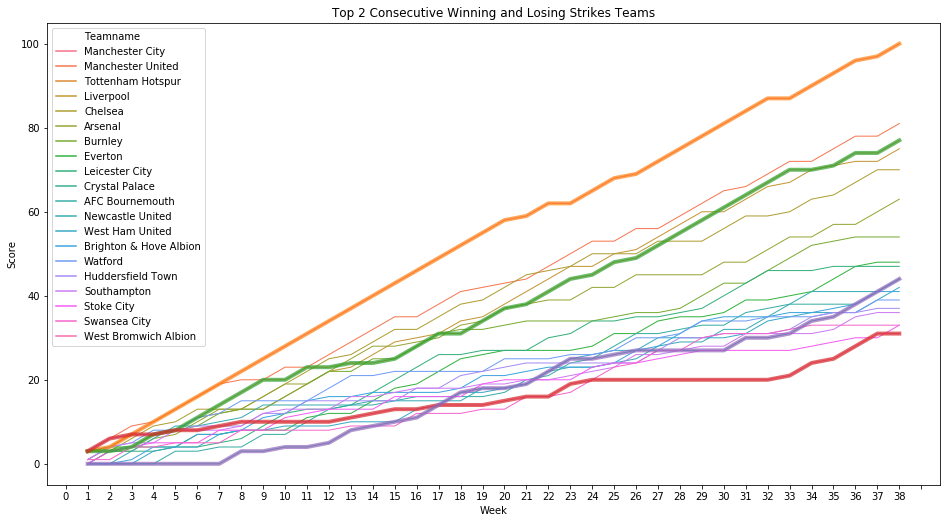

In [8]:
df1 = win.iloc[0:2]
df2 = lose.iloc[0:2]
w = []
l = []
for i,row in df1.iterrows():
    w.append(row['Teamid'])
for i,row in df2.iterrows():
    l.append(row['Teamid'])
    
#List for top teams
hue_list=list(dataf.loc[dataf["Week"]==38].sort_values(by=["Score"],ascending=False)["Teamname"])
#plotting graph
plt.figure(figsize=(16,8.5))
ax= sns.lineplot(x="Week", y="Score",legend ="full",hue ="Teamname",hue_order= hue_list
                 ,sort=True,units="Teamid", estimator=None, lw=1,data=dataf)
ax.set_xticks(range(0,50))
ax.set_xticklabels(range(0,39))
plt.title("Top 2 Consecutive Winning and Losing Strikes Teams")
for i in w:
    df=dataf.loc[dataf['Teamid']==i]
    plt.plot(df['Week'], df['Score'], marker='', linewidth=4, alpha=0.7)
for i in l:
    df=dataf.loc[dataf['Teamid']==i]
    plt.plot(df['Week'], df['Score'], marker='', linewidth=4, alpha=0.7)
plt.show()
#below graph will show all the teams played in Premier League with their weakly scores along with highlights of top two winning
#_strikes and top two losing strikes

Analysis from the Graph:

As we can see from above graph that **"Manchester City"** has the most winning strike as well as topped in Total score at the end of Week 38. 
    
Where as we can see very less gradual increase and mostly a strandard straight line for the team **"West Bromwich Albion"** and also in the last of the table at the end of the week 38. 

The Top Two consecutive Winning Strike Teams are **Manchester City** and **Tottenham Hotspur** (Although Tottenham Hotspur stands in 3rd of the table at the end of the week 38.

The top two consecutive Losing strike Teams are **West Bromwich Albion** and **Crystal Palace** (Although Crystal Palace stands top 10 of the table at the end of the week 38.

## [RQ2]  Is there a home-field advantage?

We are going to select randomly the five teams in order to create our sample.

In [9]:
teams_area = json_normalize(teams['area'])
#Taking wyId of the Premiere League teams, which have teams_area['id'] == '0'
PremiereLeagueId = [x for x in teams['wyId'][teams_area['id'] == '0']]

#We choose randomly 5 teams
rd.seed(123)
five_teams = list(rd.sample(PremiereLeagueId, 5))

#Showing the five teams selected
print('These are the five teams randomly selected:')
for x in five_teams:
    name = [x for x in teams['name'][teams['wyId'] == x]]
    print(x, name[0])

These are the five teams randomly selected:
1673 Huddersfield Town
1639 Stoke City
10531 Swansea City
1624 Tottenham Hotspur
1611 Manchester United


So, now, we are going to create the Contingency Tables of each team (and appending them to a list) and the 'Overall' one, which does not include the matches between the selected five teams.

We check and save the result of each match played by the five teams using the column winner of the matches dataset, which says to us the id of the winner of that match (for the draws, its value is 0).

In [10]:
#Dataframe containing all the Playing Side and the Outcome of the matches played by the 5 teams
Overall = pd.DataFrame(columns = ['Playing Side', 'Outcome'])

Cont_tables = []

for x in five_teams:
    #this is the dataframe containing the Playing Side and the Outcome of the matches played by a single team
    df = pd.DataFrame(columns = ['Playing Side', 'Outcome'])
    for i in range(len(matches)):
        for k in matches['teamsData'][i]:
            if k == str(x): 
                if matches['winner'][i] == x:
                    outcome = 'Win'
                elif matches['winner'][i] == 0:
                    outcome = 'Draw'
                else:
                    outcome = 'Lose'
                df = df.append({'Playing Side': matches['teamsData'][i][k]['side'].capitalize(),
                                   'Outcome' : outcome}, ignore_index = True)
                #here we have the id of the teams which played this match
                a = list(map(int, list(matches['teamsData'][i].keys())))
#if the difference between the two sets isn't 3, so only one of the five teams selected is involved in the match 
                if len(set(five_teams) - set(a)) != 3:
                    Overall = Overall.append({'Playing Side': matches['teamsData'][i][k]['side'].capitalize(),
                                              'Outcome' : outcome}, ignore_index = True)
            
    #Contingency Table of the single team                      
    Contingency_table = pd.crosstab(df['Outcome'], df['Playing Side'], margins = True, margins_name = 'Total')
    Cont_tables.append(Contingency_table)
    
#'Overall' Contingency Table 
Total_Contingency_table = pd.crosstab(Overall['Outcome'], Overall['Playing Side'], margins = True, 
                                      margins_name = 'Total')
    
#We print all the 5 contingency tables and the 'Overall' one
for i in range(len(five_teams)):
    a = [x for x in teams['name'][teams['wyId'] == int(five_teams[i])]]
    print('This is the contingency table of:', a[0], ('\n'*2), Cont_tables[i], ('\n'*3))

print('This is the contingency table where are involved all the five teams selected, excluding the matches played between', '\n', 'the five teams:')
Total_Contingency_table

This is the contingency table of: Huddersfield Town 

 Playing Side  Away  Home  Total
Outcome                        
Draw             5     5     10
Lose            11     8     19
Win              3     6      9
Total           19    19     38 



This is the contingency table of: Stoke City 

 Playing Side  Away  Home  Total
Outcome                        
Draw             7     5     12
Lose            10     9     19
Win              2     5      7
Total           19    19     38 



This is the contingency table of: Swansea City 

 Playing Side  Away  Home  Total
Outcome                        
Draw             6     3      9
Lose            11    10     21
Win              2     6      8
Total           19    19     38 



This is the contingency table of: Tottenham Hotspur 

 Playing Side  Away  Home  Total
Outcome                        
Draw             4     4      8
Lose             5     2      7
Win             10    13     23
Total           19    19     38 



This is 

Playing Side,Away,Home,Total
Outcome,,,
Draw,22,15,37
Lose,31,26,57
Win,22,34,56
Total,75,75,150


Now we are going to test, with che Chi-squared Test, the following Hypotesis:
- **H0** : There is no association between the outcome and the playing side of a match
- **H1** : There is association between the outcome and the playing side of a match

In [11]:
#Calculating the chi-squared considering only the observed values
observed_values = np.array([Total_Contingency_table.iloc[0][0:2],
                            Total_Contingency_table.iloc[1][0:2],
                            Total_Contingency_table.iloc[2][0:2]])

chi2, p_value, df, exp_values = stats.chi2_contingency(observed_values)
print(chi2, p_value)

4.334349386980966 0.11450065980784875


The **p-value** is pretty high even for a significance level of 10%, so we can't reject the null hypotesis H0. This means that we can **NOT** say that:
 1. The playing side and the outcome of a match are associated;
 2. There is an home-field advantage.

## [RQ3] Which teams have the youngest coaches?

In [12]:
matches.head()

,competitionId,date,dateutc,duration,gameweek,label,referees,roundId,seasonId,status,teamsData,venue,winner,wyId,team1,team2
0,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Burnley - AFC Bournemouth, 1 - 2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",Turf Moor,1659,2500089,1646,1659
1,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Crystal Palace - West Bromwich Albion, 2 - 0","[{'refereeId': 381851, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",Selhurst Park,1628,2500090,1628,1627
2,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Huddersfield Town - Arsenal, 0 - 1","[{'refereeId': 384965, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",The John Smith's Stadium,1609,2500091,1609,1673
3,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Liverpool - Brighton & Hove Albion, 4 - 0","[{'refereeId': 385704, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",Anfield,1612,2500092,1651,1612
4,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Manchester United - Watford, 1 - 0","[{'refereeId': 381853, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",Old Trafford,1611,2500093,1644,1611


Based on the columns of the dataframe, we need the information in "teamsData" to find out all the coaches where in the Premier League.

The type of "df_1" that we split from the dataset is "series" and the type of elements in series are "dictionary" that included 

a lot of data about the team. We just need the "teamId" and "coachId" in this "dict".

In [13]:
matches_1 = matches['teamsData']

print(type(matches_1))

<class 'pandas.core.series.Series'>


In order to find out the youngest coach in each team, we create a dataframe with 2 columns : "teamId" and "coachId".

In the "for loop", we analyze each row that as we said before, its type is "dictionary" and convert it to a dataframe.

After that, we extract the data and added to the empty dataframe that created before.

In [14]:
coach_eng = pd.DataFrame({'teamId':[], 'coachId':[]},dtype=(int,int))

for i in range(len(matches_1)):
    
    dicts = matches_1[i]
    
    a = pd.DataFrame(dicts)
    
    coach_eng = coach_eng.append(pd.DataFrame(
        
        {'teamId':list(a.loc['teamId']), 'coachId':list(a.loc['coachId'])}),ignore_index = True)

Now, we have the Id of all coaches in each team.

To find out the age of the coaches, we have to use coaches' dataset that included the birthdate of all the coaches.

In this Dataframe, "birthdate" and "wyId"(the identifier of the coach that is equal to coachId) is needed for solving the 

question. So, we remove other columns and work with these two columns.

In [15]:
display(coaches)

coaches_1 = coaches[['birthDate','wyId']]

,birthArea,birthDate,currentTeamId,firstName,lastName,middleName,passportArea,shortName,wyId
0,"{'id': 76, 'alpha2code': 'BR', 'alpha3code': '...",None,0,César Domingo,Mendiondo López,,"{'id': 76, 'alpha2code': 'BR', 'alpha3code': '...",Cesar Domingo,275580
1,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...",1945-05-09,0,Josef,Heynckes,,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...",J. Heynckes,14710
2,"{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...",1956-06-16,0,Giovanni,De Biasi,,"{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...",G. De Biasi,135480
3,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",1965-08-14,674,Marcelino,García Toral,,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",Marcelino,210074
4,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...",1974-04-02,0,Tayfun,Korkut,,"{'id': 792, 'alpha2code': 'TR', 'alpha3code': ...",T. Korkut,293398
5,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",1964-02-09,676,Ernesto,Valverde Tejedor,,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",Ernesto Valverde,92894
6,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",1967-04-22,0,Juan Carlos,Unzué Labiano,,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",Unzué,3880
7,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...",1967-12-29,0,Dirk,Schuster,,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...",D. Schuster,17121
8,"{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...",1969-07-31,0,Antonio,Conte,,"{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...",A. Conte,20454
9,"{'id': 32, 'alpha2code': 'AR', 'alpha3code': '...",1958-02-10,0,Ricardo Alberto,Gareca Nardi,,"{'id': 32, 'alpha2code': 'AR', 'alpha3code': '...",R. Gareca,86604


In this step, we merge the dataframe that was created from matches' dataset with the dataframe of coaches'dataset.

We use "coachId" and "wyId" in order for each dataframe as a joint.

Because the "coachId" and "wyId" have the same data, we eliminate one of them.

In [16]:
#join coaches that be in the league with their birthdate

age = pd.merge(coach_eng, coaches_1, left_on = 'coachId', right_on = 'wyId', how = 'inner')

age = age[['teamId','coachId','birthDate']]

In this part, we want to draw the distribution of ages of all the coaches.

For this purpose, define a dataframe that removed duplicated data based on the "coachId" by using drop_duplicates() build-in 

function and by date_range() function and calculation the length of its output, calculate the age of each coach.

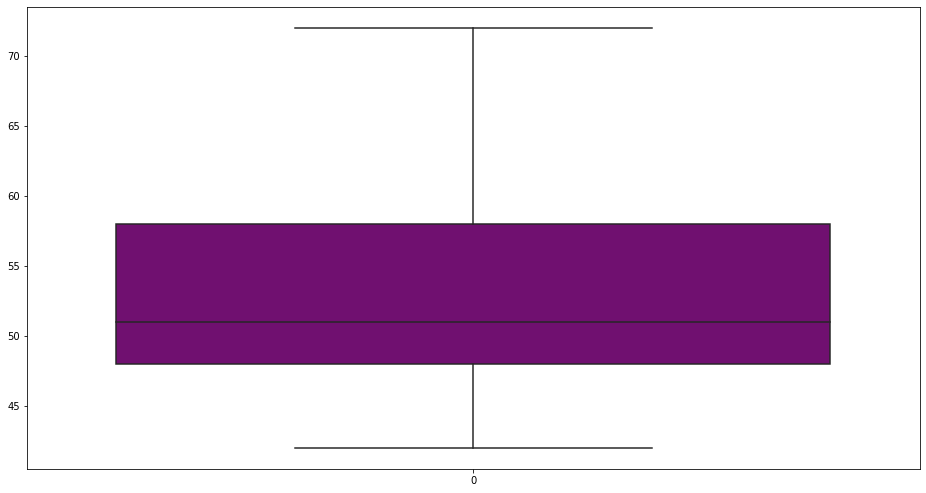

In [17]:
#remove duplicate row based on coachId

all_coaches = age.drop_duplicates(['coachId'])

all_coaches = all_coaches.reset_index()

all_coaches = all_coaches[['coachId', 'birthDate']]

#calculate the age of each coach

for k in range(len(all_coaches)): 
    
    all_coaches.loc[k,'age'] = len(pd.date_range(start = all_coaches['birthDate'][k], 
                                                 end = datetime.today().strftime('%Y-%m-%d'), freq = 'Y'))
    
#draw boxplot distribution
plt.figure(figsize=(16,8.5))
sns.boxplot(data = all_coaches['age'], orient = 'v',color = 'purple')

We can see how most of the coaches are 47 - 52 years old ( IQR of this ditribution), and they are not younger than 42 years old and older than 58 years old. There are just two outliers with age 61 and age 70.

The type of "birthDate" column is "str". So, for finding the youngest coach in each team, first we can find the youngest coach 

in each team by sorting the value of str(birthdate) in a descending way and then remove duplicate rows based on "teamId". As a 

result, the "drop_duplicates" function keeps the first row that is the smallest value for each team and we have the youngest 

coach for all of the teams.

In [18]:
#sort the birthdate values descending

age = age.sort_values(['teamId','birthDate'],ascending=[True, False])

#find youngest coach in each team:

age = age.drop_duplicates(['teamId'])

At last, we should show the 10 teams with the youngest coaches. So, we use sort_value() function, clean data and print the 

result

In [19]:
#find youngest coaches in England by sorting method

age = pd.merge(age, teams, left_on = 'teamId', right_on = 'wyId', how = 'inner')

age = age.sort_values(['birthDate'],ascending=[False])

age = age.reset_index()

age = age[['coachId','teamId', 'name', 'birthDate']]

age.head(10)

,coachId,teamId,name,birthDate
0,8934,1659,AFC Bournemouth,1977-11-29
1,71037,1644,Watford,1977-07-12
2,8214,1631,Leicester City,1975-12-04
3,434992,1623,Everton,1973-10-16
4,531745,1613,Newcastle United,1973-02-19
5,292863,1624,Tottenham Hotspur,1972-03-02
6,381291,10531,Swansea City,1972-01-08
7,18572,1673,Huddersfield Town,1971-10-19
8,254174,1619,Southampton,1971-10-05
9,8880,1646,Burnley,1971-06-28


So these are the 10 teams with the youngest coaches.

## [RQ4] Find the top 10 players with the highest ratio between completed passes and attempted passes

We are going to calculate the ratios between completed passes, which has tag = 1801 in the column tag of the events dataset, and attempted passes for each player in order to find out the top 10 players with the highest value of this ratio.

So we are going to take only the events which are passes and search the ones with tag = 1801.

In [20]:
passes = events[events['eventName'] == 'Pass']
passes.reset_index(inplace = True)

#We know all the players who made a Pass
attempted_passes = [x for x in passes['playerId']]

#We know all the players who made a Completed Pass
completed_passes = []
for i in range(len(passes)):
    for k in passes['tags'][i]:
        if k.get('id') == 1801:
            completed_passes.append(passes['playerId'][i])
            
#In this way we know the number of attempted passes and completed passes made by each player                  
n_attempted_passes = Counter(attempted_passes)
n_completed_passes = Counter(completed_passes)

Now we have to take a treshold of minimum attempted passes in order to have a more realistic statistic study:
so, in order to know a 'good' value for the treshold of minimum attempted passes, we can study their distribution with data visualization.

In [21]:
attempted = pd.Series(sorted(n_attempted_passes.values()))

Text(0.5, 1.0, 'Distribution of attempted passes made by each player')

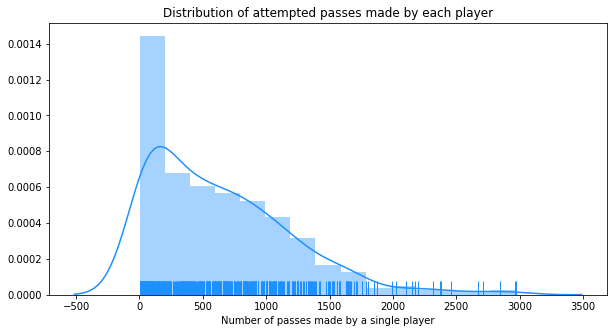

In [22]:
f, ax = plt.subplots(figsize=(10, 5))
sns.distplot(attempted, rug = True, color = 'dodgerblue', axlabel = 'Number of passes made by a single player')
plt.title('Distribution of attempted passes made by each player')

Text(0.5, 1.0, 'Boxplot of attempted passes made by each player')

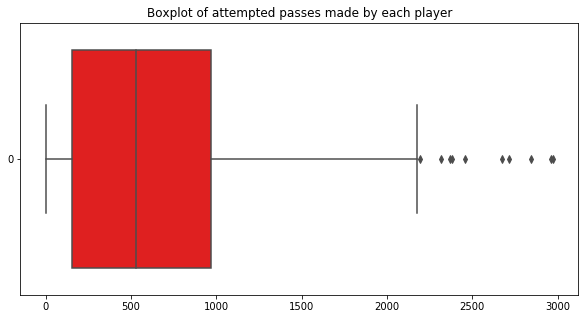

In [23]:
f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data = attempted, orient = 'h', color = 'r')
plt.title('Boxplot of attempted passes made by each player')

We can see from the previous plots that most of players didn't do so much passes and the passes for each players are distributed asymmetrically with a median smaller than the mean.
So, by looking at the distribution of the attempted passes, we can consider the third quartile of this distribution as the treshold of minimum attempted passes.

In [24]:
third_quartile = np.percentile(list(n_attempted_passes.values()), 75) 

#We create an empty DataFrame with wyId (of the players), Attempted Passes and Completed Passes as columns
players_ratio = pd.DataFrame(columns = ['wyId', 'Attempted Passes', 'Completed Passes'])

#We fill the empty values of the DataFrame 
for k in n_attempted_passes:
    if n_attempted_passes[k] >= third_quartile  and k in n_completed_passes:
        players_ratio = players_ratio.append({'wyId' : k, 'Attempted Passes' : n_attempted_passes[k], 
                                                    'Completed Passes' : n_completed_passes[k]}, ignore_index = True)
        
#we calculate the ratios: completed passes / attempted passes for each player
players_ratio['Ratio'] = players_ratio['Completed Passes'] / players_ratio['Attempted Passes']

#We sorted the DataFrame by 'Ratio' in a descending order
players_ratio.sort_values(by = ['Ratio'], inplace = True, ascending = False)       

#We merged the previous dataframe with the ones containing the players in order to know thei names
sorted_players_full = pd.merge(players_ratio, players, on = 'wyId', how = 'inner')

#We change manually the firstName and the LastName of some of the players because they are not written in the
#right way (e.g. İlkay is written /u0130lkay )
sorted_players_full.at[5, 'firstName'] = 'Nicolás Hernán'
sorted_players_full.at[6, 'firstName'] = 'İlkay' 
sorted_players_full.at[6, 'lastName'] = 'Gündoğan'
sorted_players_full.at[7, 'lastName'] = 'Dembélé'

#print the top 10 players with the highest ratios
print('These are the top 10 players with the highest ratio between completed passes and attempted passes:')
sorted_players_full[['firstName', 'lastName', 'Attempted Passes', 'Completed Passes', 'Ratio']].iloc[0:10]

These are the top 10 players with the highest ratio between completed passes and attempted passes:


,firstName,lastName,Attempted Passes,Completed Passes,Ratio
0,John,Stones,1204,1175,0.975914
1,Fabian,Delph,1584,1497,0.945076
2,Vincent,Kompany,1391,1312,0.943206
3,Andreas,Christensen,1288,1211,0.940217
4,Phil,Jones,1057,992,0.938505
5,Nicolás Hernán,Otamendi,2964,2779,0.937584
6,İlkay,Gündoğan,1350,1263,0.935556
7,Moussa Sidi Yaya,Dembélé,1365,1273,0.932601
8,Ragnar,Klavan,1130,1052,0.930973
9,Fernando Luiz,Rosa,2842,2609,0.918015


Text(0.5, 1.0, 'Top ten players with the highest ratio between completed passes and attempted passes')

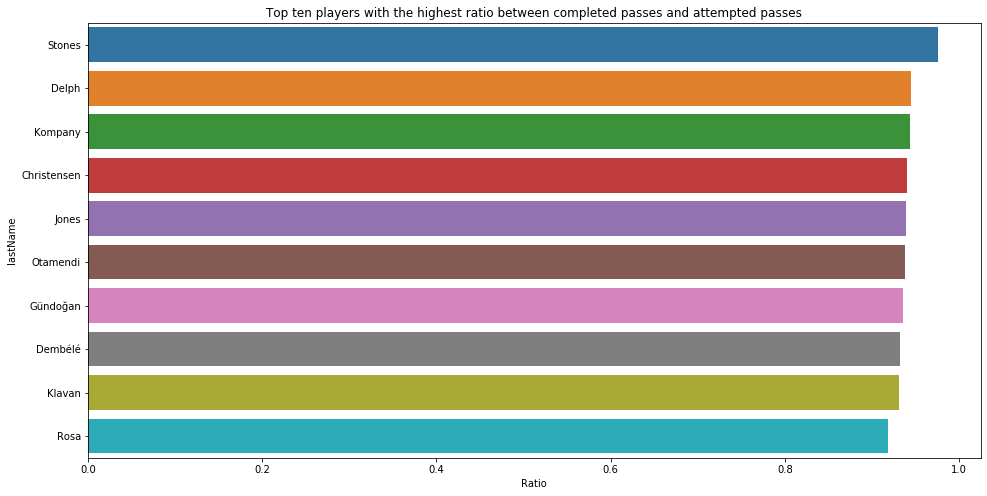

In [25]:
#showing barplot of the top 10 players
plt.figure(figsize = (16, 8))
sns.barplot(y = 'lastName', x = 'Ratio', data = sorted_players_full.iloc[0:10])
plt.title('Top ten players with the highest ratio between completed passes and attempted passes')

These are the top 10 players with the highest ratio between completed passes and attempted passes.

## [RQ5] Does being a tall player mean winning more air duels? 

In this question, we should check the dependency between height of the player and the ratio of air duels won with air duels attempted. So, we use events and players datasets.

In [26]:
#selecting wyId(playerId) and heights of all players
player = players[['wyId','height']]

In this section, we use conditional statement on "subEventName" column in order to get a series of True and False values.

We gain to "Air duel"s subevents by filtering True values in the main dataframe. 

In [27]:
#filter subevent by boolean values

is_AD =  events['subEventName']=='Air duel'

AD = events[is_AD]

#clean the dataFrame and show the columns that we need

AD = AD[['playerId','subEventName','tags']]

type(is_AD)

pandas.core.series.Series

We convert the type of "tags" to "str". All we need in this list is the key value of last element which is 1801 or 1802.

In [28]:
#clean tags column that can be filtered easily:

AD = AD.astype({'tags':'str'})

AD['tags'] = AD['tags'].map(lambda x: str(x)[-6:-2])  #now we can see just 1801 (win) or 1802 (lose) 

In [29]:
#merging Air duel subevent with players' height:

x = (pd.merge(AD,player,left_on='playerId', right_on='wyId', how='inner'))[['playerId','subEventName','tags','height']]

x = x.sort_values(['height','playerId'])

x = (x.reset_index())[['playerId','subEventName','tags','height']]

display(x.head(3))

,playerId,subEventName,tags,height
0,62224,Air duel,1801,163
1,62224,Air duel,1802,163
2,62224,Air duel,1802,163


In this part, we count the total air duels each player do and the times that each player win in the air duels.

In [30]:
#create a dataframe that shows playerId, height, number of air duals, number of win air duals:

win = x.groupby('playerId')['tags'].apply(lambda x:(x=='1801').sum()).reset_index(name='win')

total = x.groupby('playerId')['tags'].count().reset_index(name='total')

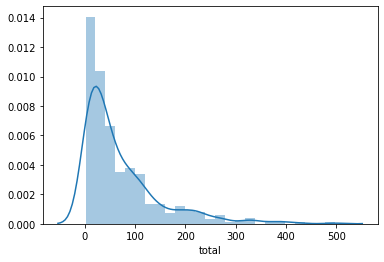

In [31]:
sns.distplot(total['total'])

Here, we should determine a threshold of minimum air duels attempted. For this purpose, draw the distribution of air duels

attempted. As the plot shows the maximum air duels attemped in the (0,100) range. But, we decided to choose players that

has >=100 air duels. Because in this situation can get realistic results

In this part, we remove players with air duels less than 100.

By joining updated total air duels with "win" dataframe on the right, we would remove players who doesn't satisfy the 

determined threshold.

In [32]:
#the total >=100

total1=total[total['total']>=100]

#join two dataframe and filter 

final=(pd.merge(win,total1,left_on='playerId', right_on='playerId', how='right'))[['playerId','win','total']]

#calculating ratio (win/total) 

final['ratio']=final['win']/final['total']

#adding height of players

final=(pd.merge(final,x,left_on='playerId', right_on='playerId', how='left'))[['playerId','height','win','total','ratio']]

final=final.drop_duplicates(['playerId']).reset_index()

In this part,we consider different range for heights and each player would be allocated to a special range based on his height.

After that, we add this series to the main dataframe and by rename the columns' name, we finalize the dataframe.

In [33]:
ranges = final['height'].apply(lambda x:'160-165' if x <= 165   else 
                            ('165-170' if (x>165 and x<=170) else 
                            ('170-175' if (x>170 and x<=175) else 
                            ('175-180'if (x>175 and x<=180)  else
                            ('180-185'if(x>180 and x<=185)   else
                            ('185-190'if(x>185 and x<=190)   else 
                            ('190-195'if (x>190 and x<=195)  else
                            ('195-200'if (x>195 and x<=200)  else '>200'))))))))

In [34]:
final=pd.concat([final, ranges], axis=1)
final.columns=['index','playerId','height','win','total','ratio','range']

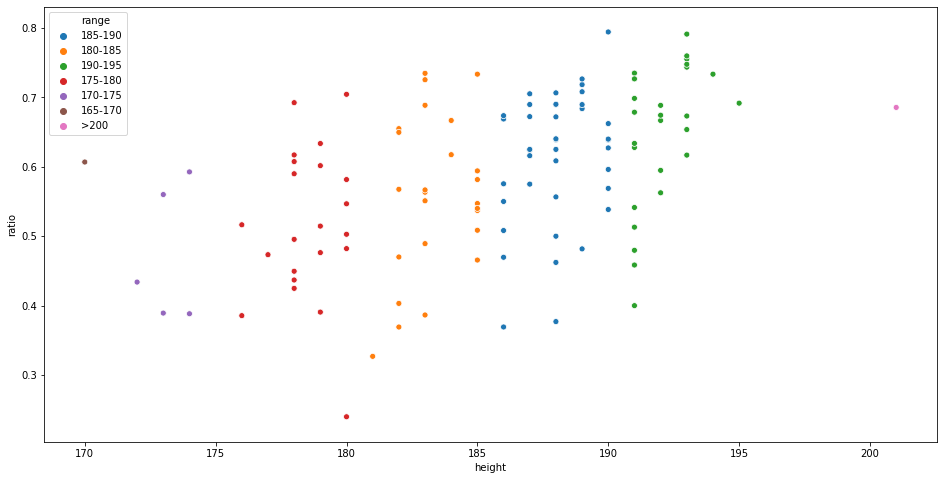

In [35]:
#draw scatter plot
plt.figure(figsize = (16, 8))
sns.scatterplot(data=final,x="height",y="ratio",hue='range')

Result: Based on the plot, it seems that when the height increases, also the ratio increases. So, we can consider that there is dependency between height of the player and the ratio of air duels won with air duels attempted. 

## [RQ6] EDA: There is a relation between the matches won without conceded goals and the strength of the goalkeepers of each team?

We are going to study if the number of matches won without conceded goals for each team is influenced by the strength of all the goalkeepers of that team. In order to evaluate the strength of all the goalkeepers, we are going to look for the ratio between completed saves / attempted saves made by all the goalkeepers of each team.

First of all we are going to considerate only the events which are saves and take the completed ones by using the tag = 1801 in the tags column of events dataset. Obviously they have to be made by goalkeepers.

In [36]:
#We created a DataFrame with only the saves
save = events[['eventId', 'eventName', 'tags', 'playerId', 'teamId', 'matchId']][events['eventId'] == 9]

#We take only the goalkeepers
roles = json_normalize(players['role'])
goalkeepers = players[['firstName', 'lastName', 'shortName', 'wyId']][roles['code2'] == 'GK']

#we know all the saves made by a goalkeeper
save_goalkeepers = pd.merge(save, goalkeepers, left_on = 'playerId', right_on = 'wyId', how = 'inner' )

#we know also the information about the teams
save_goalkeepers = pd.merge(save_goalkeepers, teams[['name', 'officialName', 'wyId']], left_on = 'teamId', 
                            right_on = 'wyId', how = 'inner')

So now we are going to evaluate the ratio of saves completed / saves attempted for each team.

In [37]:
#We know all the goalkeepers which has at least one goalkeeper who made an attempted save
attempted_saves = [x for x in save_goalkeepers['teamId']]

#We know all the teams which has at least one goalkeeper who made a completed save
completed_saves = []
for i in range(len(save_goalkeepers)):
    for k in save_goalkeepers['tags'][i]:
        if k.get('id') == 1801:
            completed_saves.append(save_goalkeepers['teamId'][i])
            
#In this way we know the number of saves made by all the goalkeepers of each team               
n_attempted_saves = Counter(attempted_saves)

#We know the number of positively completed saves made by all the goalkeepers of each team
n_completed_saves = Counter(completed_saves)

#We create an empty DataFrame with wyId (of the teams), Attempted Saves and Completed Saves as columns
teams_saves = pd.DataFrame(columns = ['wyId', 'Attempted Saves', 'Completed Saves'])

#I fill the values of the DataFrame
for k in n_attempted_saves:
    if  k in n_completed_saves: 
        teams_saves = teams_saves.append({'wyId' : k, 'Attempted Saves' : n_attempted_saves[k], 
                                        'Completed Saves' : n_completed_saves[k]}, ignore_index = True)
        
#Here I calculate the ratios: completed saves / attempted saves for each team 
teams_saves['Ratio'] = teams_saves['Completed Saves']/teams_saves['Attempted Saves']

#I merged the previous dataframe with the ones containing the players in order to know their names
teams_saves = pd.merge(teams_saves, save_goalkeepers, left_on = 'wyId',
                        right_on = 'teamId', how = 'inner')

teams_saves = teams_saves.drop_duplicates('teamId')
teams_saves.reset_index(inplace = True)

print('These are the ratios between completed saves and attempted saves made by all the goalkeepers for each team:')
teams_saves[['name', 'teamId', 'Attempted Saves', 'Completed Saves', 'Ratio']].head()

These are the ratios between completed saves and attempted saves made by all the goalkeepers for each team:


,name,teamId,Attempted Saves,Completed Saves,Ratio
0,Leicester City,1631,173,113,0.653179
1,Arsenal,1609,159,108,0.679245
2,Brighton & Hove Albion,1651,196,142,0.72449
3,Manchester City,1625,89,62,0.696629
4,Chelsea,1610,132,94,0.712121


Now we are going to take the id of all the teams who won a match without conceded goals.

In [38]:
winners_dont_concede = []
for i in range(len(matches)):
#the column 'label' of the matches dataset has at ith row at the position [-5] and [-1] the scores of the first team
#and the second team
    scores = [matches['label'][i][-5], matches['label'][i][-1]]
    #we are only considering the possibility that a team made a score < 10, as it is very extreme the opposite
    if '0' in scores and matches['winner'][i] != 0:
        winners_dont_concede.append(matches['winner'][i])
        
#we know for each team the number of times it doesn't concede goals to the opposing team in a match where it won
n_dont_concede = Counter(winners_dont_concede)

#creating a dataframe with the columns as team id and number of matches won without conceded goals
df_dont_concede = pd.DataFrame(columns = ['teamId', 'N_not_conceding'])
for k in n_dont_concede:
    df_dont_concede = df_dont_concede.append({'teamId' : k, 'N_not_conceding' : n_dont_concede[k]}, 
                                                ignore_index = True) 
    
print('These are the matches won without conceded goals for each team:')
df_dont_concede.head()

These are the matches won without conceded goals for each team:


,teamId,N_not_conceding
0,1628,5
1,1609,11
2,1612,13
3,1611,16
4,1613,8


In the end we study the relation between the matches won without conceded goals and the ratio of completed / attempted saves the goalkeepers of each team.

In [39]:
#Merging the datasets with the ratios for each team and the one with the number of matches won without conceded goals
relation_df = pd.merge(teams_saves, df_dont_concede, on = 'teamId', how = 'inner')

Text(0.5, 1.0, 'Linear Regression')

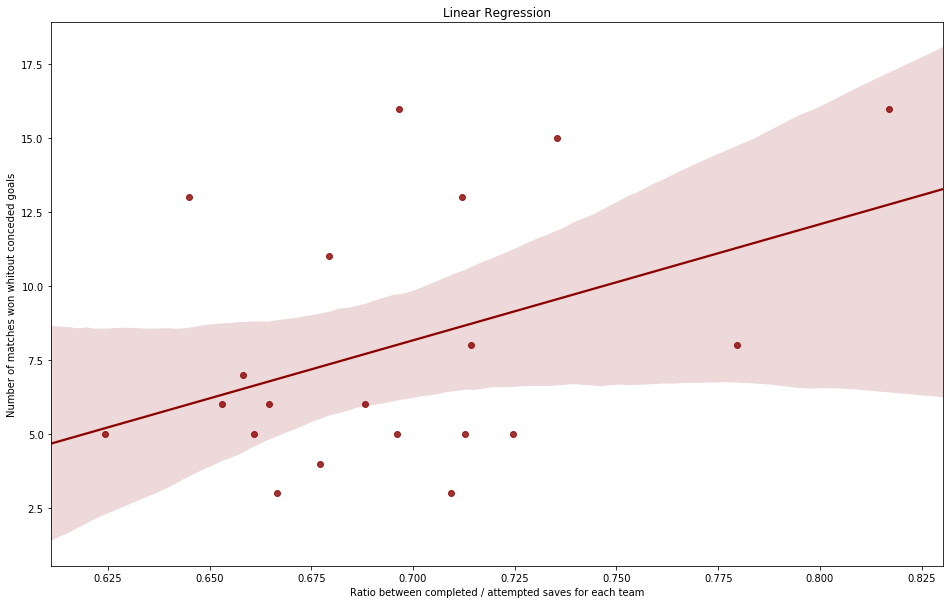

In [40]:
#plotting the relationship between the number of match won without conceded goals and
#the ratio of completed / attempted saves
X = pd.Series(relation_df['Ratio'], name = "Ratio between completed / attempted saves for each team", dtype = float)
Y = pd.Series(relation_df['N_not_conceding'], name = "Number of matches won whitout conceded goals", dtype = float)
f = plt.subplots(figsize=(16, 10))
sns.regplot(x = X, y = Y, color = 'darkred')
plt.title('Linear Regression')

It doesn't seem that there is a linear correlation between the number of matches won withouth conceded goals to the opposing team and the ratios of completed saves / attempted saves made by each team just by looking at the plot.

We can go further with our analysis by studying this linear regression.

In [41]:
gradient, intercept, r_value, p_value, std_err = stats.linregress(X,Y)
R_squared = r_value**2
print(R_squared, p_value)

0.17042313178241952 0.07045127631413899


Considering the following hypotesis:
- **H0** : The coefficient of the Ratio is not significant

- **H1** : The coefficient of the Ratio is significant

By looking at the **p-value** we can NOT reject the null hypotesis, as the p-value is equal to 0.07 which is higher than a significance level of 0.05, so we can NOT say that there is correlation between the matches won by a team without conceded goals and the ratio of completed / attempted saves of each team.
Even by looking at the **R-squared**, its value is very small, proofing that:
1. Maybe there is no correlation between our two variables;

2. Or, maybe, the matches won without conceded goals are not explained only by the ratio of completed / attempted saves, but there are other factors that could be significant for our analysis (e.g. the strength of the defenders).

## [CRQ1] What are the time slots of the match with more goals?

In [42]:
matches_eng = matches
#creating new dataframe with required columns and to load useful data 
data = pd.DataFrame(columns = ["MatchID", "TeamID", "PlayerID", "Goal", "Winner", "Slot", "TimeSlot"])

Finding the Goal Events from the Dataset we took tags to identify goal events such that tag 101 along with 1801 we are 
considering as acurate goal event and also we are taking own goal events as 102 which will add goal to the opponent

In [43]:
#storing tags and looping through events data and check if tags are present if so store it in list for future usage
g1=[{'id':1801},{'id':101},{'id':102}]
event_goal=[]
event_own_goal=[]
for i,event in events.iterrows():
    tags = event["tags"]
    if (g1[0] in tags) & (g1[1] in tags):
        event_goal.append(event["id"])
    elif(g1[2] in tags):
        event_own_goal.append(event["id"])

#### I. Make a barplot with the absolute frequency of goals in all the time slots.

Finding goal events details and storing into new dataframe data

In [44]:
for event in event_goal:
    #for each event in goal events taking out details from the events dataset like, winner, time, matchid,team, 
    #and player data
    row = events.loc[events["id"] == event]
    goal = "Goal"
    winner = row["teamId"].item()
    time = row["eventSec"].item()/60
    t = row["matchPeriod"].item()
    match = row["matchId"].item()
    team = row["teamId"].item()
    player = row["playerId"].item()
    #calculating slot for event by comparing time of the event and assigning to specif slot below is for 1st half
    if t == "1H":
        if ((time >= 0) and (time < 9)) :
            slot = "[0-9]"
            i = 1
        elif time >= 9 and time < 18 :
            slot = "[9-18]"
            i = 2
        elif time >= 18 and time < 27 :
            slot = "[18-27]"
            i = 3
        elif time >= 27 and time < 36 :
            slot = "[27-36]"
            i = 4
        elif time >= 36 and time <= 45:
            slot = "[36-45]"
            i = 5
        elif time > 45:
            slot = "[45+]"
            i = 6
        temp = {"MatchID": match, "TeamID" : team, "PlayerID":player, "Goal":goal, "Winner":winner, "Slot":i,
                "TimeSlot":slot} 
        #inserting data into "data" dataframe
        data=data.append(temp, ignore_index=True)
        #below is for second half of the match categorizing events based on the time it happend
    elif t == "2H":
        if time >= 0 and time < 9 :
            slot = "[45-54]"
            i = 7
        elif time >= 9 and time < 18 :
            slot = "[54-63]"
            i = 8
        elif time >= 18 and time < 27 :
            slot = "[63-72]"
            i = 9
        elif time >= 27 and time < 36 :
            slot = "[72-81]"
            i = 10
        elif time >= 36 and time <= 45:
            slot = "[81-90]"
            i = 11
        elif time > 45:
            slot = "[90+]"
            i = 12
        temp = {"MatchID":match, "TeamID":team, "PlayerID":player, "Goal":goal, "Winner":winner, "Slot":i,
                "TimeSlot":slot}
        #inserting into "data" dataframe
        data = data.append(temp, ignore_index = True)
    #below is for extra half 1
    elif t == "E1":
        slot = "[45+]"
        i = 6
        temp = {"MatchID":match, "TeamID":team, "PlayerID":player, "Goal":goal, "Winner":winner, "Slot":i, 
                "TimeSlot":slot}
        data = data.append(temp, ignore_index = True)
    #below is for extra half 2
    elif t == "E2":
        slot = "[90+]"
        i = 12
        temp = {"MatchID":match, "TeamID":team, "PlayerID":player, "Goal":goal, "Winner":winner, "Slot":i, 
                "TimeSlot":slot}
        data = data.append(temp, ignore_index=True)

Finding the goal winner of the own goal events by locating with matches datasets

In [45]:
for event in event_own_goal:
    #for each event in own_goal events taking out details from the events dataset like, 
    #winner, time, matchid,team, and player data
    row = events.loc[events["id"] == event]
    goal = "Own_Goal"
    winner = row["teamId"].item()
    time = row["eventSec"].item()/60
    t = row["matchPeriod"].item()
    match = row["matchId"].item()
    team = row["teamId"].item()
    match_row = matches_eng.loc[matches_eng["wyId"] == match]
    k = match_row["teamsData"].item()
    k = list(map(int,k))
    winner = k[0] if k[0] != team else k[1]
    player = row["playerId"].item()
    #categorize the even based on time slots below for 1st half
    if t == "1H":
        if ((time >= 0) and (time < 9)) :
            slot = "[0-9]"
            i = 1
        elif time >= 9 and time < 18 :
            slot = "[9-18]"
            i = 2
        elif time >= 18 and time < 27 :
            slot = "[18-27]"
            i = 3
        elif time >= 27 and time < 36 :
            slot = "[27-36]"
            i = 4
        elif time >= 36 and time <= 45:
            slot = "[36-45]"
            i = 5
        elif time > 45:
            slot = "[45+]"
            i = 6
        temp = {"MatchID":match, "TeamID":team, "PlayerID":player, "Goal":goal,"Winner":winner,"Slot":i,"TimeSlot":slot}
        data = data.append(temp, ignore_index=True)
        #categorize events for second half of the match
    elif t == "2H":
        if time >= 0 and time < 9 :
            slot = "[45-54]"
            i = 7
        elif time >= 9 and time < 18 :
            slot = "[54-63]"
            i = 8
        elif time >= 18 and time < 27 :
            slot = "[63-72]"
            i = 9 
        elif time >= 27 and time < 36 :
            slot = "[72-81]"
            i = 10
        elif time >= 36 and time < 45:
            slot = "[81-90]"
            i = 11
        elif time > 45:
            slot = "[90+]"
            i = 12
        temp = {"MatchID":match, "TeamID":team, "PlayerID":player, "Goal":goal, "Winner":winner,"Slot":i, 
                "TimeSlot":slot}
        data = data.append(temp, ignore_index = True)
    elif t == "E1":
        slot = "[45+]"
        i = 6
        temp = {"MatchID":match, "TeamID":team, "PlayerID":player, "Goal":goal, "Winner":winner, "Slot":i, 
                "TimeSlot":slot}
        data = data.append(temp, ignore_index = True)
    elif t == "E2":
        slot = "[90+]"
        i = 12
        temp = {"MatchID":match, "TeamID":team, "PlayerID":player, "Goal":goal, "Winner":winner, "Slot":i,
                "TimeSlot":slot}
        data = data.append(temp, ignore_index=True)

In [46]:
data=data.sort_values(by="Slot")
#grouping data based on Time Slot of the match
x = Counter(data["TimeSlot"])
#creating new dataframe for visualization
df = pd.DataFrame(columns= ['Intervals', 'Goals'])
for k in x:
    df = df.append({'Intervals' : k, 'Goals' : x[k]}, ignore_index=True)

Text(0.5, 1.0, 'Goals in Different time interval')

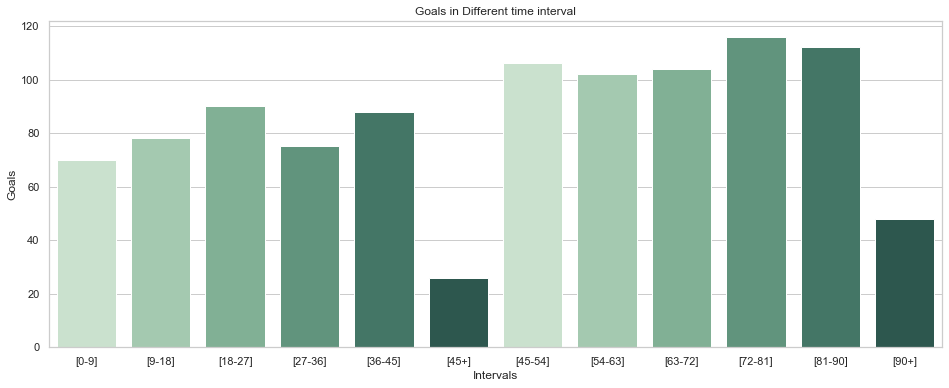

In [47]:
#Plotting the Data
plt.figure(figsize=(16, 6))
sns.set(style='whitegrid')
ax = sns.barplot(x="Intervals",y="Goals",data=df,palette=sns.color_palette("ch:2.5,-.2,dark=.3"))
plt.title("Goals in Different time interval")
#Below graph is differentiated with two intervals with color shades

Analysis from Graph:

As we can se from the graph that there is an gradual increase in the goals with respect to time period. 

It is nature that the matches will be interesting as the players will try hard to make their team win at the end of the match rather than starting phase of the match.

And also on the other hand if you are losing your game and as time period getting close to end you will try hard to make goals.


#### II. Find the top 10 teams that score the most in the interval "81-90".

In order to find the top 10 teams that score the most in the interval '81-90' we are considering the own goals made by the opponent teams also.

In [48]:
#grouping teams which took goal on the time slot 81-90
data1= data.loc[data["TimeSlot"]=="[81-90]"]
data2 = data1.groupby(['Winner']).count()
data2 = data2.sort_values(by="Goal",ascending=False)
top_teams = []
for i,row in data2.iterrows():
    top_teams.append([i,row["Goal"]])
top_teams = top_teams[:10]

In [49]:
# list of top 10 teams which targeted more goals on the interval 81-90
top = pd.DataFrame(columns=['Team','TeamName','Goal'])
for team in top_teams:
    trow = teams.loc[teams['wyId']==team[0]]
    name = trow['officialName'].item()
    goal = team[1]
    top = top.append({'Team':team[0],'TeamName':name,'Goal':goal},ignore_index=True)
top

,Team,TeamName,Goal
0,1625,Manchester City FC,13
1,1609,Arsenal FC,12
2,1611,Manchester United FC,9
3,1610,Chelsea FC,9
4,1612,Liverpool FC,8
5,1644,Watford FC,7
6,1628,Crystal Palace FC,7
7,1624,Tottenham Hotspur FC,6
8,1633,West Ham United FC,6
9,1646,Burnley FC,5


These are top 10 teams that score the most in the interval '81-90'.

Text(0.5, 1.0, 'Top Ten Teams scored goals in interval [81-90] minutes of the Match')

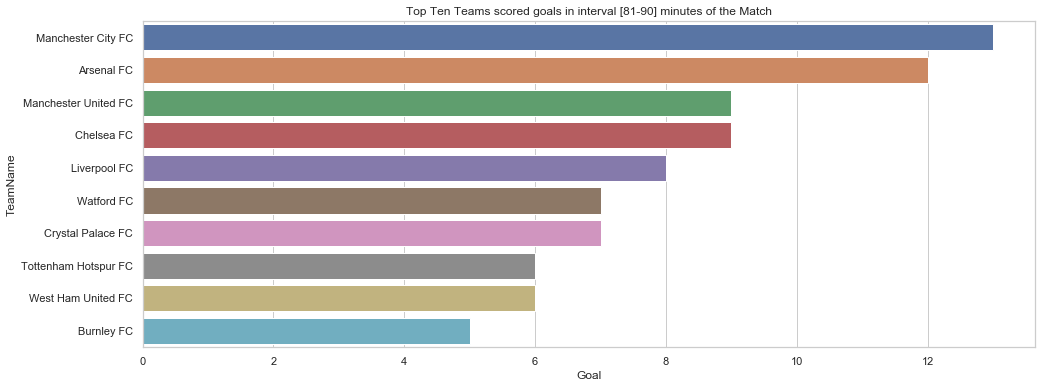

In [50]:
#visualizing
plt.figure(figsize=(16, 6))
ax = sns.barplot(y='TeamName',x='Goal',data=top)
plt.title("Top Ten Teams scored goals in interval [81-90] minutes of the Match")

#### III. Show if there are players that were able to score at least one goal in 8 different intervals.

Now we are going to group data of player who took successfull goal events and finding the players who managed to score at least one goal
in 8 different intervals.

In [51]:
new_data = data.loc[data["Goal"]=="Goal"]
play1 = new_data.groupby(["PlayerID","TimeSlot","Slot"]).size().reset_index(name='count')
play2 = play1.groupby("PlayerID").size().reset_index(name='slots')
top_players = play2.loc[play2['slots']==8]
top_players = top_players.sort_values(by='slots',ascending=False)
top_players

,PlayerID,slots
80,8422,8
131,14703,8
141,15808,8
155,25413,8


In [52]:
#creating dataframe for visualizing different slots they scored
Top = pd.DataFrame(columns=["playerID","playerName","Interval","Goals"])
for i,row in top_players.iterrows():
    pid = row['PlayerID']
    new=play1.loc[play1["PlayerID"]==pid]
    name = players.loc[players['wyId']==pid]
    fname = name['firstName'].item()+" "+name['lastName'].item()
    for j,col in new.iterrows():
        inter= col["TimeSlot"]
        goal = col["count"]
        s = col["Slot"]
        Top=Top.append({"playerID":pid,"playerName":fname,"Interval":inter,"Goals":goal,'Slot':s},ignore_index=True)

Text(0.5, 1.0, 'Players that were able to score at least one goal in 8 different intervals')

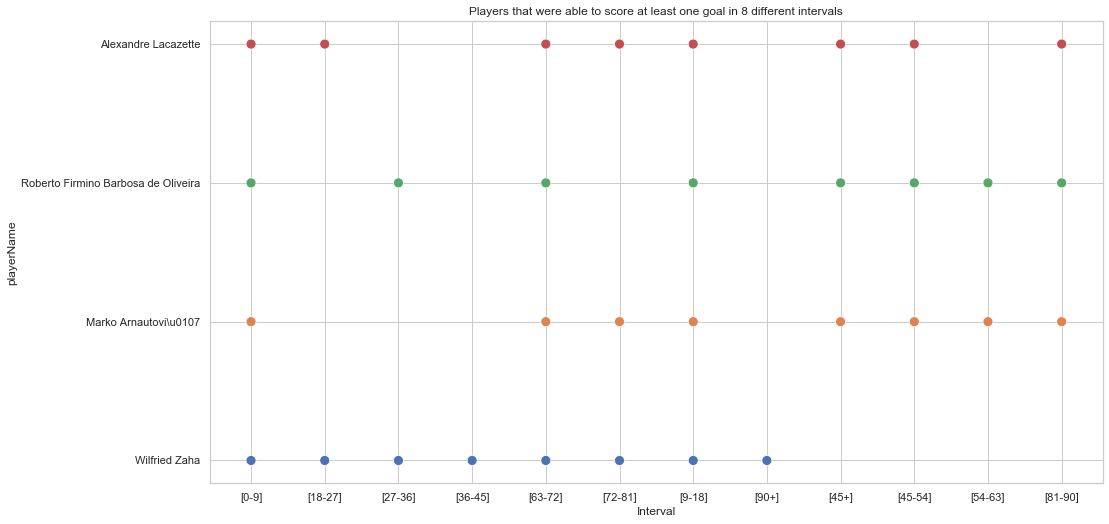

In [53]:
#showing in which intervals the players made a goal
plt.figure(figsize=(16, 8.5))
ax = sns.scatterplot(y="playerName", x="Interval", data=Top,hue="playerName",legend = False,s=100)
plt.title("Players that were able to score at least one goal in 8 different intervals")

With this scatterplot we showed in which intervals each player made a goal.

In [54]:
#top players who scored atleast one score in 8 and beyond intervals
top_players = play2.loc[play2['slots']>=8]
top_players = top_players.sort_values(by='slots',ascending=False)
top_players

,PlayerID,slots
97,8717,11
125,11066,11
129,12829,11
209,120353,11
16,3324,9
39,7905,9
172,26150,9
241,340386,9
80,8422,8
131,14703,8


On the other hand there are players who made a goal not only in 8 different intervals, but even for more intervals.

So we can also make the same analysis for them. 

In [55]:
#dataframe for visualization
Top = pd.DataFrame(columns=["playerID","playerName","Interval","Goals"])
for i,row in top_players.iterrows():
    pid = row['PlayerID']
    new=play1.loc[play1["PlayerID"]==pid]
    name = players.loc[players['wyId']==pid]
    fname = name['firstName'].item()+" "+name['lastName'].item()
    for j,col in new.iterrows():
        inter= col["TimeSlot"]
        goal = col["count"]
        s = col["Slot"]
        Top=Top.append({"playerID":pid,"playerName":fname,"Interval":inter,"Goals":goal,'Slot':s},ignore_index=True)

Text(0.5, 1.0, 'Players that were able to score at least one goal in 8 and more different intervals')

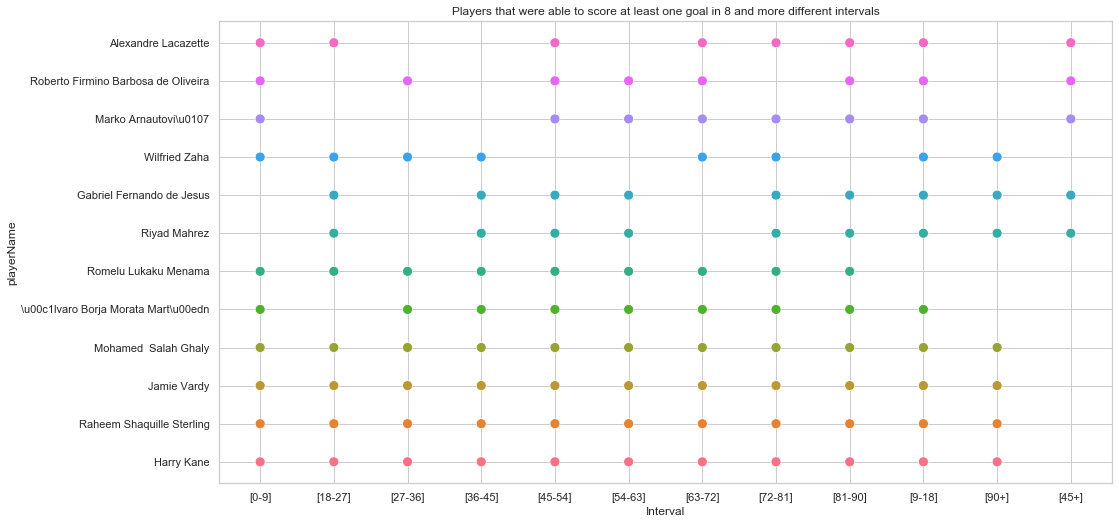

In [56]:
#visualising the same scatterplot made before but this time for the players who made at least one goal
#in different intervals.
plt.figure(figsize=(16, 8.5))
ax = sns.scatterplot(y="playerName", x="Interval", data=Top,hue="playerName",legend = False,s=100)
plt.title("Players that were able to score at least one goal in 8 and more different intervals")
#top players are arranged in y axis from 1 to n

## [CRQ2] Visualize movements and passes on the pitch!

###  Barcelona - Real Madrid played on the 6 May 2018

For the 1st part of the Second Core Request we also used the 'matches_Spain.json' and the 'events_Spain.json' datasets.

### Datasets

In [57]:
matches_Liga = pd.read_json('matches_Spain.json')
events_Liga = pd.read_json('events_Spain.json')
player1 = players

First of all, by searching the date of the match is held, we find out the matchId.

In [58]:
# eliminating the time that match is held 
    
df['dateutc'] = matches_Liga['dateutc'].map(lambda x: str(x)[:10])

#Find the matchId by using boolean values

is_date =  df['dateutc']=='2018-05-06'

df=df[is_date]

#### ===> wyId:( the identifier of the match) 2565907

Here, we find out the Ronaldo and Messi 's playerId by filtering their "birthDate"

In [59]:
#Find the playerId by using boolean values

is_BD =  player1['birthDate']=='1985-02-05'

Ronaldo=player1[is_BD]

is_BD =  player1['birthDate']=='1987-06-24'

Messi = player1[is_BD]

#### Ronaldo's Id : 3322
#### Messi's Id : 3359

We select the events that related to the matchId by boolean values.

After that the updated dataframe will be filtered based on 'Pass', 'Shot','Duel','Free Kick' events.

In [60]:
# filter evenets in  Barcelona - Real Madrid played on the 6 May 2018

df2=events_Liga[events_Liga['matchId']==2565907]

moves=df2[df2['eventName'].isin(['Pass', 'Shot','Duel','Free Kick']) ]

In [61]:
# picking out the Ronaldo and Messi 's evenets by using their Id

CR=moves[moves['playerId']==3322] #Ronaldo

LM=moves[moves['playerId']==3359] #Messi

Type of "positions" column is a list of 2 dictionaries, that converted to dataframe that the first column shows the start point 

and the second column shows the end point.

The "start point" column is a dictionary that converted to a list and by calling each element, we find out the x and y of start 

point seperately. 

In [62]:
#Ronaldo

pos=CR['positions'].apply(lambda x:pd.Series(x))

start=pos[0].apply(lambda x:list(x.values()))

x_start=list(start.apply(lambda x:x[1]*1.2))

y_start=list(start.apply(lambda x:x[0]*0.8))

#Messi

pos1=LM['positions'].apply(lambda x:pd.Series(x))

start1=pos1[0].apply(lambda x:list(x.values()))

x_start1=list(start1.apply(lambda x:x[1]*1.2))

y_start1=list(start1.apply(lambda x:x[0]*0.8))

In [63]:
def draw_field(ax):
    #Pitch Outline & Centre Line
    Pitch = Rectangle([0,0], width = 120, height = 80, color = 'black', fill = False)
    
    #Left, Right Penalty Area and midline
    LeftPenalty = Rectangle([0,22.3], width = 14.6, height = 35.3, color = 'black',fill = False)
    RightPenalty = Rectangle([105.4,22.3], width = 14.6, height = 35.3, color = 'black', fill = False)
    midline = ConnectionPatch([60,0], [60,80], "data", "data", color = 'black')

    #Left, Right 6-yard Box
    LeftSixYard = Rectangle([0,32], width = 4.9, height = 16, color = 'black', fill = False)
    RightSixYard = Rectangle([115.1,32], width = 4.9, height = 16, color = 'black', fill = False)

    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black", fill = False)
    centreSpot = plt.Circle((60,40),0.71,color="black")
    
    #Penalty spots and Arcs around penalty boxes
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")
    
    #Arcs
    leftArc = Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")
    
    element = [Pitch, LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc]
    
    #Draw all the elements
    for i in element:
        ax.add_patch(i)

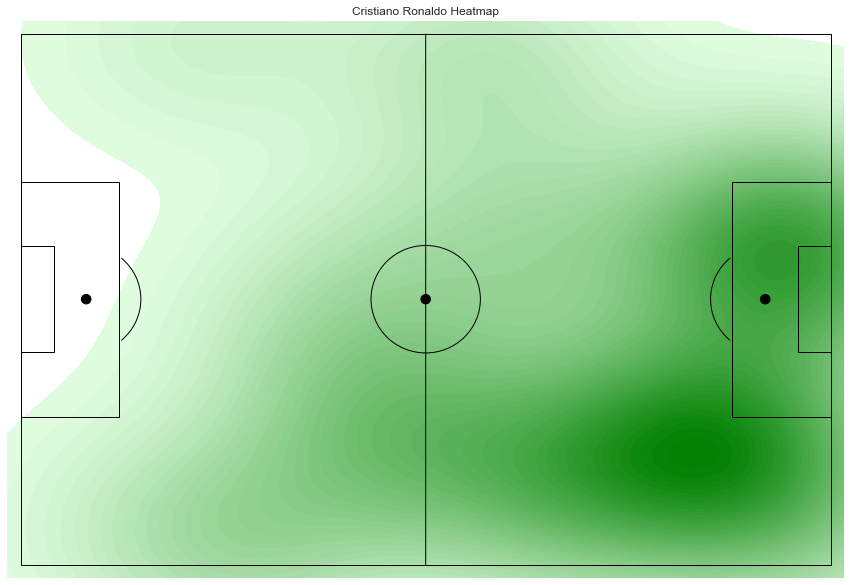

In [64]:
#draw heatmap plot 
##Ronaldo

fig=plt.figure() #set up the figures
fig.set_size_inches(15, 10.25)
ax=fig.add_subplot(1,1,1)
draw_field(ax) #overlay our different objects on the pitch
plt.ylim(-2, 82)
plt.xlim(-2, 122)
plt.axis('off')
plt.title('Cristiano Ronaldo Heatmap')

#shades: give us the heat map we desire
# n_levels: draw more lines, the larger n, the more blurry it looks

sns.kdeplot(x_start, y_start, shade = "True", color = "green", n_levels = 50, shade_lowest=False)

plt.show()   

 Cristiano Ronaldo has two main areas where he was most active:
- the first one is the right wing of the field;
- the other one is the penalty area of the team rival.


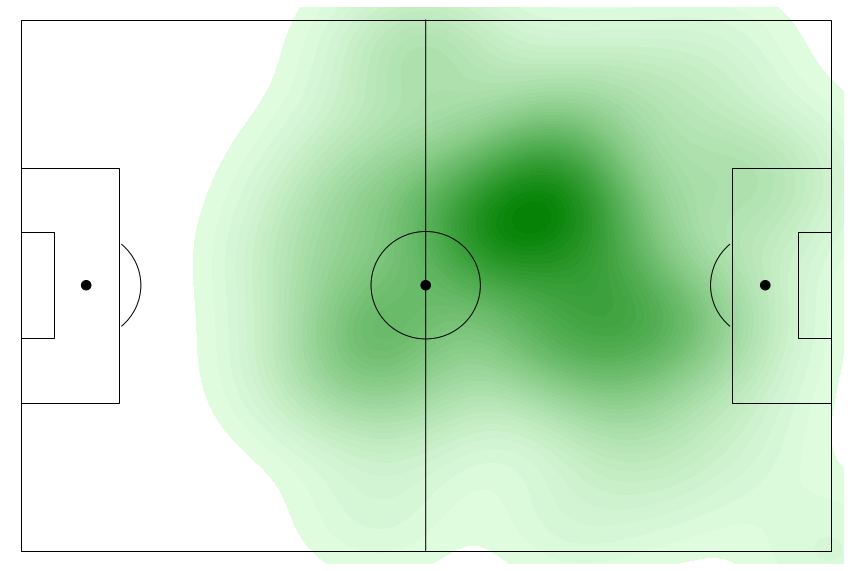

In [65]:
#draw heatmap plot 
##Messi

fig=plt.figure() #set up the figures
fig.set_size_inches(15, 10.25)
ax=fig.add_subplot(1,1,1)
draw_field(ax) #overlay our different objects on the pitch
plt.ylim(-2, 82)
plt.xlim(-2, 122)
plt.axis('off')

#shades: give us the heat map we desire
# n_levels: draw more lines, the larger n, the more blurry it looks

sns.kdeplot(x_start1, y_start1, shade = "True", color = "green", n_levels = 50,shade_lowest=False)

plt.show()

Messi, instead, played mostly only in one area of the field, which goes from the midfield to the area just before the penalty zone.

Comparing the two heatmaps, we can see how different is their playing style in this match:
- Ronaldo played almost everywhere, especially near the opposing door, switching from the right wing to the front of the door and covering a pretty big area of the field;
- Messi played quite far from the door, remaining in the same main area of the field for the entire match and covering a smaller area than Ronaldo's.

### 2. Juventus - Napoli played on the 22 April 2018

For the 2nd part of the second Core Request we also used the 'matches_Italy.json' and the 'events_Italy.json' datasets.

### Datasets

In [66]:
events_serieA = pd.read_json('events_Italy.json')
matches_SerieA = pd.read_json('matches_Italy.json')

We are going to look for the id of the match we are interested in

In [67]:
a = [str(x) for x in teams['wyId'][teams['name'] == 'Juventus']]
b = [str(x) for x in teams['wyId'][teams['name'] == 'Napoli']]
Juve_Napoli = [a[0], b[0]]
match = []
for i in range(len(matches_SerieA)):
    x = matches_SerieA['teamsData'][i].keys()
    #if the differentce of the two sets is equal to zero it means that both teams are involved in the same match
    if len(set(Juve_Napoli) - set(x)) == 0:
        match.append(matches_SerieA.iloc[i]['wyId'])

We take only the events which are passes and they are made in the match we are looking for

In [68]:
#p.s. is the [0] because the matches are saved starting from the last ones to the previous ones
events_juve_napoli = events_serieA.loc[(events_serieA['eventName'] == 'Pass') & (events_serieA['matchId'] == match[0])]

#We save on two differents Dataframes the Data about Jorginho and Pjanic
Jorginho = players[['wyId', 'firstName', 'lastName']][players['firstName'] == 'Jorge Luiz']
Pjanic = players[['wyId', 'firstName', 'lastName']][players['firstName'] == 'Miralem']

#We create two different dataframes with all the events made by Jorginho and Pjanic in that match
events_Jorginho = pd.merge(events_juve_napoli, Jorginho, left_on = 'playerId', right_on = 'wyId', how = 'inner')
events_Pjanic= pd.merge(events_juve_napoli, Pjanic, left_on = 'playerId', right_on = 'wyId', how = 'inner')

We are going to take all the starting and ending coordinates of the attempted passes and completed passes made by Jorginho and Pjanic and store them in 4 different dataframes: two for the attempted passes of each player and to for the completed passes of each player.

In [69]:
#In this two dataframes we store in one all the coordinates of all passes and 
#in the other only the completed passes (event tag = 1801) made by Jorginho
Jorginho_attempted = pd.DataFrame(columns = ['Ystart', 'Xstart', 'Yend', 'Xend'])
Jorginho_completed = pd.DataFrame(columns = ['Ystart', 'Xstart', 'Yend', 'Xend'])

for i in range(len(events_Jorginho)):
    keys = events_Jorginho['positions'][i]
    Jorginho_attempted = Jorginho_attempted.append({'Ystart' : keys[0]['y'], 'Xstart' : keys[0]['x'], 
                                                    'Yend' : keys[1]['y'], 'Xend' : keys[1]['x']}, 
                                                     ignore_index = True)
    for k in events_Jorginho['tags'][i]:
        if k.get('id') == 1801:
            Jorginho_completed = Jorginho_completed.append({'Ystart' : keys[0]['y'], 'Xstart' : keys[0]['x'], 
                                                            'Yend' : keys[1]['y'], 'Xend' : keys[1]['x']}, 
                                                             ignore_index = True)
            
#In this two dataframes we store in one all the coordinates of all passes and in the
#other only the completed passes (event tag = 1801) made by Pjanic            
Pjanic_attempted = pd.DataFrame(columns = ['Ystart', 'Xstart', 'Yend', 'Xend'])
Pjanic_completed = pd.DataFrame(columns = ['Ystart', 'Xstart', 'Yend', 'Xend'])   

for i in range(len(events_Pjanic)):
    keys = events_Pjanic['positions'][i]
    Pjanic_attempted = Pjanic_attempted.append({'Ystart' : keys[0]['y'], 'Xstart' : keys[0]['x'], 
                                                'Yend' : keys[1]['y'], 'Xend' : keys[1]['x']}, 
                                                 ignore_index = True)
    for k in events_Pjanic['tags'][i]:
        if k.get('id') == 1801:
            Pjanic_completed = Pjanic_completed.append({'Ystart' : keys[0]['y'], 'Xstart' : keys[0]['x'], 
                                      'Yend' : keys[1]['y'], 'Xend' : keys[1]['x']}, ignore_index = True)

We are going to plot the arrow maps with all the attempted passes made by Jorginho and Pjanic.

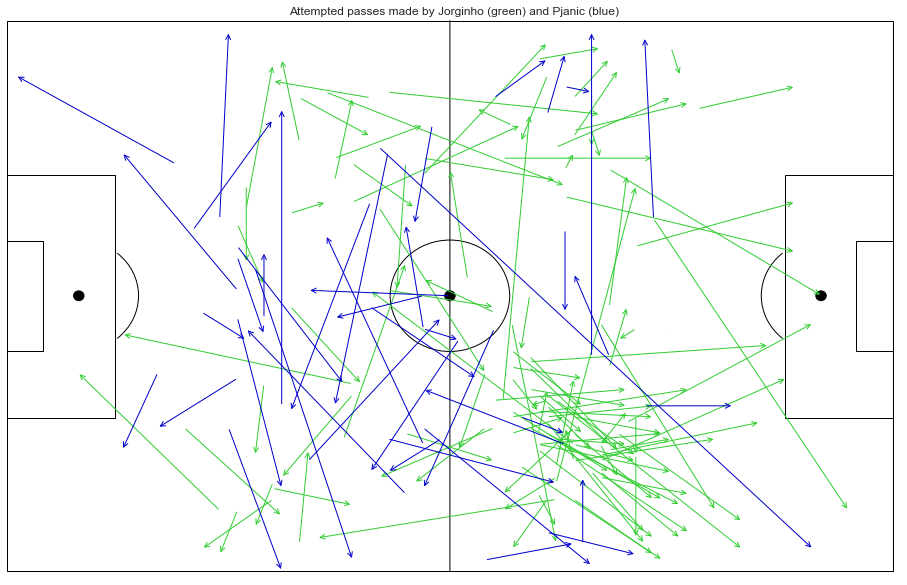

In [70]:
fig=plt.figure() #set up the figures
fig.set_size_inches(16, 10.25)
ax=fig.add_subplot(1,1,1)
draw_field(ax) #overlay our different objects on the pitch
plt.ylim(-1, 80)
plt.xlim(0, 121)
plt.title('Attempted passes made by Jorginho (green) and Pjanic (blue)')
    
#Tidy Axes
plt.axis('off')
    
for i in range(len(Jorginho_attempted)):
# annotate draw an arrow from the start position to the end position of the attempted passes made by Jorginho
# we need to rescale the ccordinates as the printed field has 120x80 size, while the coordinates of the 
# dataset are referring to a 100x100 field
    ax.annotate("", xy = (Jorginho_attempted.iloc[i]['Xend']*1.2, Jorginho_attempted.iloc[i]['Yend']*0.8), 
            xycoords = 'data', xytext = (Jorginho_attempted.iloc[i]['Xstart']*1.2, 
            Jorginho_attempted.iloc[i]['Ystart']*0.8), textcoords = 'data', 
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "limegreen"),)

for i in range(len(Pjanic_attempted)):
    # annotate draw an arrow from the start position to the end position of the attempted passes made by Pjanic
    # we need to rescale the ccordinates as the printed field has 120x80 size, while the coordinates of the 
    # dataset are referring to a 100x100 field
    ax.annotate("", xy = (Pjanic_attempted.iloc[i]['Xend']*1.2, Pjanic_attempted.iloc[i]['Yend']*0.8),
                xycoords = 'data', xytext = (Pjanic_attempted.iloc[i]['Xstart']*1.2, 
                Pjanic_attempted.iloc[i]['Ystart']*0.8), textcoords = 'data',
                arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "mediumblue"),)
        
#Display Pitch
plt.show()

We are now going to plot the arrowmap with only the completed passes made by Jorginho and Pjanic

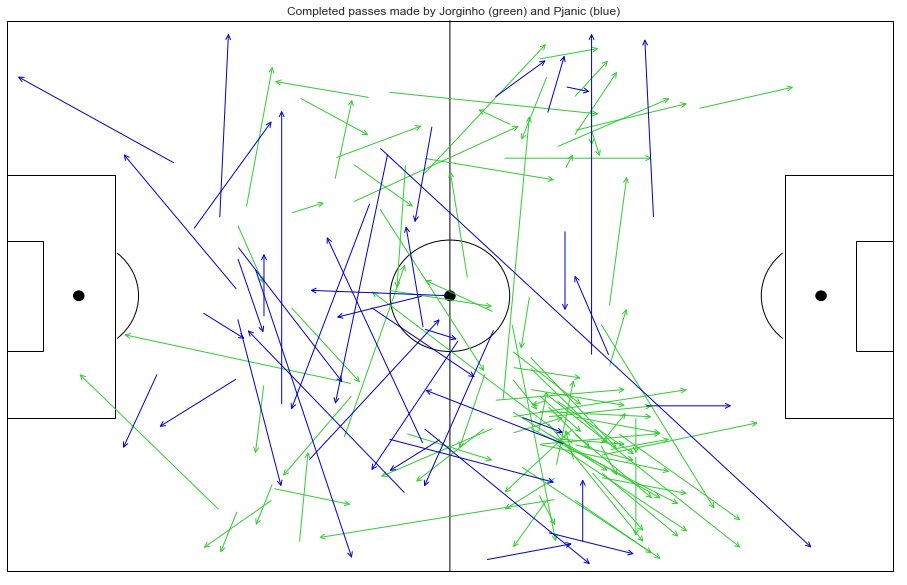

In [73]:
fig=plt.figure() #set up the figures
fig.set_size_inches(16, 10.25)
ax=fig.add_subplot(1,1,1)
draw_field(ax) #overlay our different objects on the pitch
plt.ylim(-1, 80)
plt.xlim(0, 121)
plt.title('Completed passes made by Jorginho (green) and Pjanic (blue)')
    
#Tidy Axes
plt.axis('off')
    
for i in range(len(Jorginho_completed)):
# annotate draw an arrow from the start position to the end position of the completed passes made by Jorginho
# we need to rescale the ccordinates as the printed field has 120x80 size, while the coordinates of the 
# dataset are referring to a 100x100 field
    ax.annotate("", xy = (Jorginho_completed.iloc[i]['Xend']*1.2, Jorginho_completed.iloc[i]['Yend']*0.8), 
            xycoords = 'data', xytext = (Jorginho_completed.iloc[i]['Xstart']*1.2, 
            Jorginho_completed.iloc[i]['Ystart']*0.8), textcoords = 'data', 
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "limegreen"),)

for i in range(len(Pjanic_completed)):
    # annotate draw an arrow from the start position to the end position of the completed passes made by Pjanic
    # we need to rescale the ccordinates as the printed field has 120x80 size, while the coordinates of the 
    # dataset are referring to a 100x100 field
    ax.annotate("", xy = (Pjanic_completed.iloc[i]['Xend']*1.2, Pjanic_completed.iloc[i]['Yend']*0.8),
                xycoords = 'data', xytext = (Pjanic_completed.iloc[i]['Xstart']*1.2, 
                Pjanic_completed.iloc[i]['Ystart']*0.8), textcoords = 'data',
                arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "mediumblue"),)
        
#Display Pitch
plt.show()

We can see how Jorginho (green arrows) made much more passes than Pjanic (blue arrows), but he failed more at the same time. Precisely, Jorginho failed the passes to the penalty area of the team rival, which are very important for his team in order to make some goals. Instead, Pjanic did almost only completed passes.

Also, we can see that Jorginho played mostly on the right side of the field, while Pjanic covered all the field but the penalty area of the opposing team without having a favourite field's side, making even very long successful passes that go from one half side of the field to the other one.

So, we can say that Pjanic played a more tactical and polished game, while Jorginho played a more impulsive and active game.